# Load and Pre-process Data

In [6]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
from tqdm import tqdm

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV


import pickle
import spacy
import ast

import pyLDAvis
import pyLDAvis.gensim  
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 800)
pd.set_option('display.max_columns', 500)



import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to C:\Users\Devdatta
[nltk_data]     Supnekar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Devdatta
[nltk_data]     Supnekar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
df = pd.read_csv("bbc-text.csv")
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [8]:
stop_words = stopwords.words('english')
file = open("stopwords/extended_stopwords.txt", "r")
stop_words.extend([line.strip() for line in file.readlines()])
file.close()
file = open("stopwords/contractions.txt", "r")
contractions = ast.literal_eval(file.read())
file.close()

In [9]:
print(df.category.unique())

['tech' 'business' 'sport' 'entertainment' 'politics']


In [10]:
# Convert to list
data = df.text.values.tolist()
print(len(data))

2225


In [12]:

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'"," ", sent) for sent in data]

pprint(data[0])

('tv future in the hands of viewers with home theatre systems plasma '
 'high-definition tvs and digital video recorders moving into the living room '
 'the way people watch tv will be radically different in five years time. that '
 'is according to an expert panel which gathered at the annual consumer '
 'electronics show in las vegas to discuss how these new technologies will '
 'impact one of our favourite pastimes. with the us leading the trend '
 'programmes and other content will be delivered to viewers via home networks '
 'through cable satellite telecoms companies and broadband service providers '
 'to front rooms and portable devices. one of the most talked-about '
 'technologies of ces has been digital and personal video recorders (dvr and '
 'pvr). these set-top boxes like the us s tivo and the uk s sky+ system allow '
 'people to record store play pause and forward wind tv programmes when they '
 'want. essentially the technology allows for much more personalised tv. they 

In [14]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence).encode('utf-8'), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))
print(data_words[0])


['tv', 'future', 'in', 'the', 'hands', 'of', 'viewers', 'with', 'home', 'theatre', 'systems', 'plasma', 'high', 'definition', 'tvs', 'and', 'digital', 'video', 'recorders', 'moving', 'into', 'the', 'living', 'room', 'the', 'way', 'people', 'watch', 'tv', 'will', 'be', 'radically', 'different', 'in', 'five', 'years', 'time', 'that', 'is', 'according', 'to', 'an', 'expert', 'panel', 'which', 'gathered', 'at', 'the', 'annual', 'consumer', 'electronics', 'show', 'in', 'las', 'vegas', 'to', 'discuss', 'how', 'these', 'new', 'technologies', 'will', 'impact', 'one', 'of', 'our', 'favourite', 'pastimes', 'with', 'the', 'us', 'leading', 'the', 'trend', 'programmes', 'and', 'other', 'content', 'will', 'be', 'delivered', 'to', 'viewers', 'via', 'home', 'networks', 'through', 'cable', 'satellite', 'telecoms', 'companies', 'and', 'broadband', 'service', 'providers', 'to', 'front', 'rooms', 'and', 'portable', 'devices', 'one', 'of', 'the', 'most', 'talked', 'about', 'technologies', 'of', 'ces', 'has

In [15]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)# higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

In [16]:
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [17]:
# See bigram example
print(bigram_mod[data_words[0]])


['tv', 'future', 'in', 'the', 'hands', 'of', 'viewers', 'with', 'home', 'theatre', 'systems', 'plasma', 'high_definition', 'tvs', 'and', 'digital', 'video_recorders', 'moving', 'into', 'the', 'living_room', 'the', 'way', 'people', 'watch', 'tv', 'will', 'be', 'radically', 'different', 'in', 'five', 'years', 'time', 'that', 'is', 'according', 'to', 'an', 'expert', 'panel', 'which', 'gathered', 'at', 'the', 'annual', 'consumer_electronics', 'show', 'in', 'las_vegas', 'to', 'discuss', 'how', 'these', 'new', 'technologies', 'will', 'impact', 'one', 'of', 'our', 'favourite', 'pastimes', 'with', 'the', 'us', 'leading', 'the', 'trend', 'programmes', 'and', 'other', 'content', 'will', 'be', 'delivered', 'to', 'viewers', 'via', 'home', 'networks', 'through', 'cable', 'satellite', 'telecoms', 'companies', 'and', 'broadband', 'service_providers', 'to', 'front', 'rooms', 'and', 'portable_devices', 'one', 'of', 'the', 'most', 'talked', 'about', 'technologies', 'of', 'ces', 'has', 'been', 'digital',

In [18]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [19]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [20]:
print(data_lemmatized[0][:50])

['tv', 'future', 'hand', 'viewer', 'theatre', 'system', 'plasma', 'tvs', 'digital', 'video_recorder', 'move', 'living_room', 'people', 'watch', 'tv', 'radically', 'year', 'time', 'expert', 'panel', 'gather', 'annual', 'consumer_electronic', 'las_vega', 'discuss', 'technology', 'impact', 'favourite', 'pastime', 'lead', 'trend', 'programme', 'content', 'deliver', 'viewer', 'network', 'cable', 'satellite', 'telecom', 'company', 'broadband', 'front', 'room', 'portable_device', 'talk', 'technology', 'ce', 'digital', 'personal', 'video_recorder']


# Text Representation with Feature Engineering

In [21]:


# Create a dictionary representation of the documents.
dictionary = gensim.corpora.Dictionary(data_lemmatized)
print('Sample word to number mappings:', list(dictionary.items())[:15])
print('Total Vocabulary Size:', len(dictionary))

Sample word to number mappings: [(0, 'abide'), (1, 'adam'), (2, 'advert'), (3, 'advertising'), (4, 'announce'), (5, 'annual'), (6, 'bbc'), (7, 'big'), (8, 'bill_gate'), (9, 'book'), (10, 'box'), (11, 'brand'), (12, 'broadband'), (13, 'broadcast'), (14, 'broadcaster')]
Total Vocabulary Size: 22424


In [22]:
# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.6)
print('Total Vocabulary Size:', len(dictionary))

Total Vocabulary Size: 2287


In [23]:
# Transforming corpus into bag of words vectors
bow_corpus = [dictionary.doc2bow(text) for text in data_lemmatized]
print(bow_corpus[1][:50])

[(7, 2), (20, 1), (25, 1), (46, 2), (66, 1), (76, 2), (82, 1), (94, 1), (121, 1), (136, 1), (137, 5), (138, 1), (139, 2), (140, 1), (141, 1), (142, 1), (143, 1), (144, 1), (145, 1), (146, 2), (147, 1), (148, 1), (149, 1), (150, 2), (151, 1), (152, 1), (153, 1), (154, 2), (155, 1), (156, 3), (157, 1), (158, 1), (159, 2), (160, 1), (161, 1), (162, 1), (163, 3), (164, 1), (165, 1), (166, 1), (167, 1), (168, 1), (169, 1), (170, 1), (171, 3), (172, 1), (173, 1), (174, 1), (175, 1), (176, 1)]


In [24]:
print([(dictionary[idx] , freq) for idx, freq in bow_corpus[1][:50]])

[('book', 2), ('chief', 1), ('company', 1), ('firm', 2), ('increase', 1), ('lose', 2), ('month', 1), ('press', 1), ('telecom', 1), ('ability', 1), ('accounting', 5), ('accuse', 1), ('admit', 2), ('allegation', 1), ('argue', 1), ('ask', 1), ('aware', 1), ('bn', 1), ('boom', 1), ('boss', 2), ('card', 1), ('claim', 1), ('client', 1), ('collapse', 2), ('comment', 1), ('competition', 1), ('cross', 1), ('decision', 2), ('declare', 1), ('defence', 3), ('distance', 1), ('economist', 1), ('entry', 2), ('expect', 1), ('face', 1), ('false', 1), ('fraud', 3), ('guilty', 1), ('hide', 1), ('house', 1), ('investor', 1), ('job', 1), ('know', 1), ('late', 1), ('lawyer', 3), ('leave', 1), ('loss', 1), ('mount', 1), ('order', 1), ('phone', 1)]


In [26]:
print('Total number of text:', len(bow_corpus))

Total number of text: 2225


# Topic Models with Latent Semantic Indexing (LSI)

In [33]:
# To run on single model 

%%time

TOTAL_TOPICS = 5
lsi_bow = gensim.models.LsiModel(bow_corpus, id2word=dictionary,chunksize=100, num_topics=TOTAL_TOPICS)

Wall time: 1.53 s


In [57]:
gensim.models.lsimodel.LsiModel?

In [58]:
def tune_model(dictionary, corpus, texts, limit, start=2, step=1):
    
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = gensim.models.lsimodel.LsiModel(corpus=corpus, 
                                       id2word=dictionary, 
                                       num_topics=num_topics,
#                                        onepass=True, 
                                       chunksize=100)
        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(round(coherencemodel.get_coherence(),3))

    return model_list, coherence_values

In [59]:
%%time

# Can take a long time to run
model_list, coherence_values = tune_model(dictionary=dictionary, corpus=bow_corpus, texts=data_lemmatized, start=2, limit=8, step=1)


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:38<00:00, 16.35s/it]

Wall time: 1min 38s


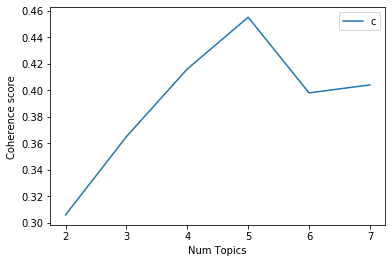

In [60]:
# Show graph
limit=8; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [61]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.306
Num Topics = 3  has Coherence Value of 0.365
Num Topics = 4  has Coherence Value of 0.416
Num Topics = 5  has Coherence Value of 0.455
Num Topics = 6  has Coherence Value of 0.398
Num Topics = 7  has Coherence Value of 0.404


In [62]:
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.320*"people" + 0.234*"game" + 0.193*"time" + 0.161*"music" + '
  '0.161*"government" + 0.136*"work" + 0.131*"play" + 0.110*"service" + '
  '0.109*"company" + 0.100*"technology"'),
 (1,
  '-0.658*"game" + 0.254*"government" + -0.253*"play" + 0.158*"labour" + '
  '0.139*"people" + 0.135*"party" + -0.122*"player" + -0.121*"time" + '
  '0.107*"increase" + 0.102*"pay"'),
 (2,
  '0.518*"music" + 0.325*"song" + -0.217*"game" + -0.180*"government" + '
  '-0.174*"labour" + 0.169*"mobile" + -0.140*"party" + 0.133*"technology" + '
  '0.103*"digital" + 0.103*"service"'),
 (3,
  '-0.540*"song" + -0.255*"music" + -0.172*"award" + -0.169*"vote" + '
  '0.164*"technology" + -0.164*"british" + 0.150*"mobile" + 0.140*"service" + '
  '-0.138*"win" + -0.116*"party"'),
 (4,
  '-0.430*"increase" + -0.407*"pay" + -0.253*"business" + -0.201*"work" + '
  '-0.187*"job" + -0.180*"song" + -0.178*"wage" + -0.133*"hour" + '
  '-0.124*"employer" + -0.124*"earn"')]


In [63]:
x = optimal_model.show_topics(num_topics=5, num_words=10, formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

# Below Code Prints Topics and Words
for topic, words in topics_words:
    print(str(topic) + "::" + str(words))
print()

print("---------------------")

0::['people', 'game', 'time', 'music', 'government', 'work', 'play', 'service', 'company', 'technology']
1::['game', 'government', 'play', 'labour', 'people', 'party', 'player', 'time', 'increase', 'pay']
2::['music', 'song', 'game', 'government', 'labour', 'mobile', 'party', 'technology', 'digital', 'service']
3::['song', 'music', 'award', 'vote', 'technology', 'british', 'mobile', 'service', 'win', 'party']
4::['increase', 'pay', 'business', 'work', 'job', 'song', 'wage', 'hour', 'employer', 'earn']

---------------------


In [64]:
import operator
from functools import reduce
from collections import defaultdict

def _document_topic_matrix(model, doc_term_matrix):

    a = reduce(operator.concat, model[doc_term_matrix])
    d = defaultdict(list)
    for tup in a:
        d[tup[0]] += (tup[1],)
    df = pd.DataFrame.from_dict(d)
    doc_topic_matrix = df.values
    return doc_topic_matrix

a = _document_topic_matrix(optimal_model, bow_corpus)

In [65]:
a

array([[10.06885308, -0.30198009,  4.56275138,  5.51599179,  0.40661574],
       [ 1.88356887,  0.80256575, -0.46540799,  0.43862339, -0.02480479],
       [ 1.90729647, -0.9801524 , -0.84371153, -0.25591819,  0.26965227],
       ...,
       [ 2.57002315, -0.44341208,  1.30557638, -1.34921432,  0.31550146],
       [ 4.87535764,  1.25393226, -2.31445794, -1.43255806,  1.2684193 ],
       [ 1.4990144 , -0.88797898, -0.65746143, -0.53285425,  0.01496946]])

In [85]:
# Get main topic in each document
for i, row in enumerate(optimal_model[bow_corpus]):
    
    sent_topics_df = pd.DataFrame()
    
    print(row)
    row = sorted(row, key=lambda x: x[1], reverse=True)
    print(row)
    
    for j, (topic_num, prop_topic) in enumerate(row):
        print(j, "topic: ", topic_num, "prob_topic", prob_topic)
    
        if j == 0:  # => dominant topic
            wp = optimal_model.show_topic(topic_num)
            print("wp: ", wp)
            topic_keywords = ", ".join([word for word, prop in wp])
            print(topic_keywords)
            sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
        else:
            break

    
    break

[(0, 10.068853075095607), (1, -0.3019800885540224), (2, 4.562751377045158), (3, 5.515991791608627), (4, 0.4066157387552592)]
[(0, 10.068853075095607), (3, 5.515991791608627), (2, 4.562751377045158), (4, 0.4066157387552592), (1, -0.3019800885540224)]
0 topic:  0 prob_topic -0.3019800885540224
wp:  [('people', 0.3199668067551834), ('game', 0.23361712132111034), ('time', 0.19277104668928277), ('music', 0.1614346650855123), ('government', 0.16087427413983885), ('work', 0.13589815279802844), ('play', 0.13095920665601019), ('service', 0.10980392265038691), ('company', 0.10916742469186534), ('technology', 0.1001407016196297)]
people, game, time, music, government, work, play, service, company, technology
1 topic:  3 prob_topic -0.3019800885540224


In [86]:
sent_topics_df.head()

,0,1,2
0,0.0,10.0689,"people, game, time, music, government, work, p..."


In [71]:
def format_topics_sentences(ldamodel=optimal_model, corpus=bow_corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):

        row = sorted(row, key=lambda x: x[1], reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=bow_corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Topic_No', 'Topic_Perc_Contrib', 'Topic_Keywords', 'Text']

final_df = df_dominant_topic.drop("Document_No", axis=1)

# # add clean text Show
# clean_text = [ " ".join(i) for i in texts]
# final_df["Clean_Text"] = clean_text

# show
final_df.head(10)

,Topic_No,Topic_Perc_Contrib,Topic_Keywords,Text
0,0.0,10.0689,"people, game, time, music, government, work, p...",tv future in the hands of viewers with home th...
1,0.0,1.8836,"people, game, time, music, government, work, p...",worldcom boss left books alone former worldcom...
2,0.0,1.9073,"people, game, time, music, government, work, p...",tigers wary of farrell gamble leicester say th...
3,0.0,2.3288,"people, game, time, music, government, work, p...",yeading face newcastle in fa cup premiership s...
4,0.0,1.9713,"people, game, time, music, government, work, p...",ocean s twelve raids box office ocean s twelve...
5,0.0,6.9026,"people, game, time, music, government, work, p...",howard hits back at mongrel jibe michael howar...
6,0.0,3.1988,"people, game, time, music, government, work, p...",blair prepares to name poll date tony blair is...
7,0.0,1.7906,"people, game, time, music, government, work, p...",henman hopes ended in dubai third seed tim hen...
8,0.0,1.3725,"people, game, time, music, government, work, p...",wilkinson fit to face edinburgh england captai...
9,0.0,1.4378,"people, game, time, music, government, work, p...",last star wars not for children the sixth and ...


In [72]:
final_df["Topic_No"].value_counts()

0.0    2185
2.0      31
1.0       8
3.0       1
Name: Topic_No, dtype: int64

In [73]:
final_df["Topic_Perc_Contrib"].value_counts()

4.3812    3
2.5013    3
1.5943    3
1.5928    3
2.7270    2
         ..
4.5645    1
7.5269    1
7.3646    1
4.4681    1
4.0625    1
Name: Topic_Perc_Contrib, Length: 2061, dtype: int64

In [87]:
TOTAL_TOPICS = 5

In [89]:
for n in range(TOTAL_TOPICS):
    print('Topic #'+str(n+1)+':')
    print('='*50)
    d1 = []
    d2 = []
    for term, wt in optimal_model.show_topic(n, topn=20):
        if wt >= 0:
            d1.append((term, round(wt, 3)))
        else:
            d2.append((term, round(wt, 3)))

    print('Direction 1:', d1)
    print('-'*50)
    print('Direction 2:', d2)
    print('-'*50)
    print()
    

Topic #1:
Direction 1: [('people', 0.32), ('game', 0.234), ('time', 0.193), ('music', 0.161), ('government', 0.161), ('work', 0.136), ('play', 0.131), ('service', 0.11), ('company', 0.109), ('technology', 0.1), ('good', 0.098), ('call', 0.094), ('film', 0.091), ('party', 0.091), ('firm', 0.09), ('win', 0.09), ('labour', 0.09), ('number', 0.089), ('player', 0.088), ('increase', 0.087)]
--------------------------------------------------
Direction 2: []
--------------------------------------------------

Topic #2:
Direction 1: [('government', 0.254), ('labour', 0.158), ('people', 0.139), ('party', 0.135), ('increase', 0.107), ('pay', 0.102), ('plan', 0.091), ('election', 0.084), ('country', 0.08), ('blair', 0.079), ('tory', 0.066)]
--------------------------------------------------
Direction 2: [('game', -0.658), ('play', -0.253), ('player', -0.122), ('time', -0.121), ('gaming', -0.101), ('win', -0.084), ('online', -0.076), ('title', -0.07), ('hour', -0.068)]
-----------------------------

In [91]:
optimal_model.projection?

In [92]:
term_topic = optimal_model.projection.u
singular_values = optimal_model.projection.s
topic_document = (gensim.matutils.corpus2dense(optimal_model[bow_corpus], len(singular_values)).T / singular_values).T
term_topic.shape, singular_values.shape, topic_document.shape

((2287, 5), (5,), (5, 2225))

In [93]:
document_topics = pd.DataFrame(np.round(topic_document.T, 3), 
                               columns=['T'+str(i) for i in range(1, TOTAL_TOPICS+1)])
document_topics.head(15)

,T1,T2,T3,T4,T5
0,0.044,-0.002,0.039,0.052,0.005
1,0.008,0.006,-0.004,0.004,-0.000
2,0.008,-0.007,-0.007,-0.002,0.003
3,0.010,-0.019,-0.017,-0.009,0.006
4,0.009,-0.005,-0.003,-0.001,0.007
5,0.030,0.033,-0.046,-0.035,0.020
6,0.014,0.022,-0.022,-0.010,0.008
7,0.008,-0.009,-0.009,-0.005,0.001
8,0.006,-0.010,-0.008,-0.003,0.003
9,0.006,-0.002,-0.000,-0.000,0.010


# Predicting Topics for New Data

In [142]:
df_test = pd.read_csv("1st_Input_df_for_tm.csv")
df_test.head()

,Unnamed: 0,Session_id,Text
0,0,BillPay call with no PII,"Welcome to Vodafone, here speaking. May I get ..."
1,1,BillPay call with no PII,it. What what is the error message you're gett...
2,2,BillPay call with no PII,"code. Okay, let me just double-check. Hold on...."
3,3,BillPay call with no PII,8080. No problem at all. Here is the PIN code ...
4,4,BillPay call with no PII,That's perfect. No worries at all. Hold on. Ju...


In [208]:
def clean_pipeline(df_test):    
    text_data = df_test.Text.values.tolist()
    print("[INFO] Total Document Before cleaning: ", len(text_data))

    data = [re.sub('\S*@\S*\s?', '', sent) for sent in text_data]
    data = [re.sub('\s+', ' ', sent) for sent in data]
    data = [re.sub("\'"," ", sent) for sent in data]
    
    data_words = list(sent_to_words(data))
    data_words_nostops = remove_stopwords(data_words)
    data_words_bigrams = make_bigrams(data_words_nostops)

    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    
    
    # check empty vocab and delete 
    empty = 0
    empty_idx = []
    empty_doc = []
#     for idx, (raw , clean) in enumerate(zip(text_data, data_lemmatized)):                                       
#         doc = " ".join(clean)
#         if len(doc) == 0:                            
#             empty += 1
#             empty_idx.append(idx)
#             empty_doc.append(raw)
                
#             del text_data[idx]
#             del data_lemmatized[idx]
            
                                    
                                        
                                        
    print("[INFO] Totoal Empty Document: ", empty)
    print("[INFO] Empty Vocab idx: ", empty_idx)
    
    # remove empty vocab texts as wll as lemmatized text


    print("[INFO] Total Document Valid Documents cleaning: ", len(data_lemmatized))
    return data_lemmatized, text_data, empty_doc

In [209]:
clean_data, raw_data, empty_raw = clean_pipeline(df_test)

[INFO] Total Document Before cleaning:  46
[INFO] Totoal Empty Document:  0
[INFO] Empty Vocab idx:  []
[INFO] Total Document Valid Documents cleaning:  46


In [ ]:
del text_data[13]

In [183]:
len(text_data)

46

In [167]:
test_data[13]

[]

In [210]:
counter = 0
empty_idx = []
for idx , (raw, clean) in enumerate(zip(raw_data, clean_data)):
    print(idx, "---"*10)
    print("raw: ",raw)
    clean_text = " ".join(clean)
    print("clean: ", clean_text )
    print("len", len(clean_text))
    if len(clean_text) == 0:
        counter = counter + 1
        empty_idx.append(idx)
    print()
    
print("No of empty strings: ", counter)
print("empty idx: ", empty_idx)

0 ------------------------------
raw:  Welcome to Vodafone, here speaking. May I get your name, please? How can I help
clean:  vodafone speak
len 14

1 ------------------------------
raw:  it. What what is the error message you're getting actually
clean:  error message
len 13

2 ------------------------------
raw:  code. Okay, let me just double-check. Hold on. The average payments every month
clean:  code double check hold average payment
len 38

3 ------------------------------
raw:  8080. No problem at all. Here is the PIN code for the security of the accounts next time. This might be just handy for you. Okay, and do you have access to the online account as well? My
clean:  problem pin code security account time handy access online account
len 66

4 ------------------------------
raw:  That's perfect. No worries at all. Hold on. Just 1 second. What type of phone you have
clean:  perfect worry hold type phone
len 29

5 ------------------------------
raw:  6. Yep. That's perfect. And 

In [211]:
def bow_features_pipeline(tokenized_docs, dictionary):
    text_bow_features = [dictionary.doc2bow(text) 
                              for text in tokenized_docs]
    return text_bow_features

norm_bow_features = bow_features_pipeline(tokenized_docs=clean_data, dictionary=dictionary)

In [206]:
len(norm_bow_features)

40

In [207]:
norm_bow_features[-1]

[]

In [199]:
clean_data[2]

['code', 'double', 'check', 'hold', 'average', 'payment']

In [132]:
print(norm_bow_features[2])

[(206, 1), (257, 1), (596, 1), (1276, 1), (1457, 1), (1554, 1)]


In [212]:
df_topic_sents_keywords_test = format_topics_sentences(ldamodel=optimal_model, corpus=norm_bow_features, texts=raw_data)
df_topic_sents_keywords_test.head(45)

,Dominant_Topic,Perc_Contribution,Topic_Keywords,0
0,0.0,0.0222,"people, game, time, music, government, work, p...","Welcome to Vodafone, here speaking. May I get ..."
1,0.0,0.0234,"people, game, time, music, government, work, p...",it. What what is the error message you're gett...
2,0.0,0.1163,"people, game, time, music, government, work, p...","code. Okay, let me just double-check. Hold on...."
3,0.0,0.4380,"people, game, time, music, government, work, p...",8080. No problem at all. Here is the PIN code ...
4,0.0,0.1513,"people, game, time, music, government, work, p...",That's perfect. No worries at all. Hold on. Ju...
5,3.0,0.2016,"song, music, award, vote, technology, british,...",6. Yep. That's perfect. And what about the is ...
6,0.0,0.0277,"people, game, time, music, government, work, p...",you. Can you go to settings just you can put t...
7,0.0,0.0937,"people, game, time, music, government, work, p...",you want to put this call on
8,0.0,0.0191,"people, game, time, music, government, work, p...",Okay. Now you need to press the middle button ...
9,0.0,0.0060,"people, game, time, music, government, work, p...","discussions. Yes, ma'am settings. Yeah, and th..."


In [202]:
df_topic_sents_keywords_test["Dominant_Topic"].value_counts()

0.0    32
2.0     4
3.0     3
Name: Dominant_Topic, dtype: int64

In [204]:
for i in empty_raw:
    print(i)

me just try anything on with the
try that and see how it goes
Well, it's anybody at home
that to help. Is there anything else I can do for now?
back. Yeah,
No, that's everything. Thank you.


# -- 

In [119]:
def get_topic_predictions(topic_model, corpus, topn=3):
    topic_predictions = topic_model[corpus]
    best_topics = [[(topic, round(wt, 3)) 
                        for topic, wt in sorted(topic_predictions[i], 
                                                key=lambda row: -row[1])[:topn]] 
                            for i in range(len(topic_predictions))]
    return best_topics

In [120]:
topic_preds = get_topic_predictions(topic_model=optimal_model, 
                                    corpus=norm_bow_features, topn=2)
topic_preds

[[(0, 0.022), (1, 0.011)],
 [(0, 0.023), (3, 0.021)],
 [(0, 0.116), (3, 0.039)],
 [(0, 0.438), (3, 0.214)],
 [(0, 0.151), (3, 0.101)],
 [(3, 0.202), (0, 0.18)],
 [(0, 0.028), (4, 0.02)],
 [(0, 0.094), (1, 0.043)],
 [(0, 0.019), (4, 0.006)],
 [(0, 0.006), (4, 0.004)],
 [(2, 0.202), (3, 0.196)],
 [(2, 0.202), (3, 0.196)],
 [(3, 0.011), (2, 0.008)],
 [],
 [(0, 0.235), (4, 0.015)],
 [(0, 0.016), (4, 0.006)],
 [(0, 0.003), (4, 0.001)],
 [(0, 0.375), (3, 0.338)],
 [],
 [(0, 0.027), (4, 0.017)],
 [(0, 0.124), (3, 0.067)],
 [(3, 0.07), (2, 0.055)],
 [(2, 0.021), (0, 0.018)],
 [(0, 0.045), (1, 0.029)],
 [(0, 0.106), (1, 0.062)],
 [(0, 0.041), (4, 0.035)],
 [(0, 0.056), (3, 0.039)],
 [],
 [(0, 0.141), (4, 0.059)],
 [(0, 0.214), (4, 0.072)],
 [(0, 0.323), (3, 0.099)],
 [(0, 0.238), (3, 0.107)],
 [(0, 0.451), (3, 0.201)],
 [(2, 0.194), (0, 0.177)],
 [(0, 0.296), (4, 0.092)],
 [],
 [(0, 0.237), (3, 0.134)],
 [(0, 0.145), (4, 0.001)],
 [(0, 0.083), (4, 0.021)],
 [(0, 0.004), (4, 0.002)],
 [],
 [(0, 